In [1]:
import fsspec
import cf_xarray #noqa
import xarray as xr
from kerchunk.netCDF3 import NetCDF3ToZarr


fs_read = fsspec.filesystem('s3', anon=True, skip_instance_cache=True, use_ssl=False) # For now SSL false is solving my cert issues **shrug**
fs_write = fsspec.filesystem('')

In [8]:
ngofs_files = fs_read.glob('s3://noaa-ofs-pds/ngofs2.20231002/nos.ngofs2.2ds.f*.20231002.t09z.nc')

ngofs_files = sorted(['s3://'+f for f in ngofs_files])
ngofs_files

['s3://noaa-ofs-pds/ngofs2.20231002/nos.ngofs2.2ds.f000.20231002.t09z.nc',
 's3://noaa-ofs-pds/ngofs2.20231002/nos.ngofs2.2ds.f001.20231002.t09z.nc',
 's3://noaa-ofs-pds/ngofs2.20231002/nos.ngofs2.2ds.f002.20231002.t09z.nc',
 's3://noaa-ofs-pds/ngofs2.20231002/nos.ngofs2.2ds.f003.20231002.t09z.nc',
 's3://noaa-ofs-pds/ngofs2.20231002/nos.ngofs2.2ds.f004.20231002.t09z.nc',
 's3://noaa-ofs-pds/ngofs2.20231002/nos.ngofs2.2ds.f005.20231002.t09z.nc',
 's3://noaa-ofs-pds/ngofs2.20231002/nos.ngofs2.2ds.f006.20231002.t09z.nc',
 's3://noaa-ofs-pds/ngofs2.20231002/nos.ngofs2.2ds.f007.20231002.t09z.nc',
 's3://noaa-ofs-pds/ngofs2.20231002/nos.ngofs2.2ds.f008.20231002.t09z.nc',
 's3://noaa-ofs-pds/ngofs2.20231002/nos.ngofs2.2ds.f009.20231002.t09z.nc',
 's3://noaa-ofs-pds/ngofs2.20231002/nos.ngofs2.2ds.f010.20231002.t09z.nc',
 's3://noaa-ofs-pds/ngofs2.20231002/nos.ngofs2.2ds.f011.20231002.t09z.nc',
 's3://noaa-ofs-pds/ngofs2.20231002/nos.ngofs2.2ds.f012.20231002.t09z.nc',
 's3://noaa-ofs-pds/ngofs

In [15]:
import ujson

def generate_json(f):
    outname = f'./ngofs2/{f.split("/")[-1]}.zarr'

    chunks = NetCDF3ToZarr(f, storage_options={'anon': True})
    with fs_write.open(outname, 'w') as ofile:
        ofile.write(ujson.dumps(chunks.translate()))

    return outname

In [16]:
print(f'Generating Zarr metadata for {ngofs_files[1]}')
print(f'Wrote Zarr metadata to {generate_json(ngofs_files[1])}')

Generating Zarr metadata for s3://noaa-ofs-pds/ngofs2.20231002/nos.ngofs2.2ds.f001.20231002.t09z.nc
Wrote Zarr metadata to ./ngofs2/s3://noaa-ofs-pds/ngofs2.20231002/nos.ngofs2.2ds.f001.20231002.t09z.nc.zarr


In [19]:
# open dataset as zarr object using fsspec reference file system and xarray
fs = fsspec.filesystem("reference", fo='./ngofs2/nos.ngofs2.2ds.f001.20231002.t09z.nc.zarr', remote_protocol='s3', remote_options={'anon':True})
m = fs.get_mapper("")

ds = xr.open_dataset(m, engine="zarr", backend_kwargs=dict(consolidated=False), chunks={}, drop_variables=['Itime2'])
ds

FileNotFoundError: [Errno 2] No such file or directory: '/Users/matthewiannucci/Developer/ocean-notebooks/ngofs2/nos.ngofs2.2ds.f001.20231002.t09z.nc.zarr/.zmetadata'

In [6]:
zeta = ds.zeta.cf.isel(time=0)
zeta

<xarray.DataArray 'zeta' (node: 303714)>
dask.array<getitem, shape=(303714,), dtype=float32, chunksize=(303714,), chunktype=numpy.ndarray>
Coordinates:
    lat      (node) float32 dask.array<chunksize=(303714,), meta=np.ndarray>
    lon      (node) float32 dask.array<chunksize=(303714,), meta=np.ndarray>
    time     datetime64[ns] 2023-09-29T15:59:56.484375008
Dimensions without coordinates: node
Attributes:
    grid:           Bathymetry_Mesh
    location:       node
    long_name:      Water Surface Elevation
    positive:       up
    standard_name:  sea_surface_height_above_geoid
    type:           data
    units:          meters

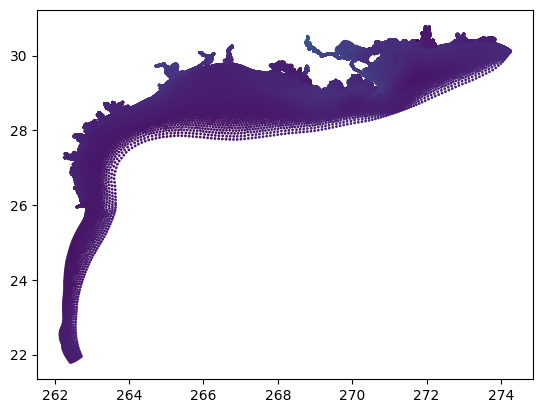

In [7]:
import matplotlib.pyplot as plt

plt.scatter(zeta.cf['longitude'], zeta.cf['latitude'], c=zeta, s=1)